In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/flickr8k.zip","r") as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
spacy_eng = spacy.load("en")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    
    def tokenizer_eng(self, text):
        self.text = text
        return [tok.text.lower() for tok in spacy_eng.tokenizer(self.text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
                self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
                for token in tokenized_text
        ]

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform = None, freq_threshold = 5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.images = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        image_id = self.images[index]
        image = Image.open(os.path.join(self.root_dir, image_id)).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value = self.pad_idx)

        return imgs, targets

In [ ]:
transform = transforms.Compose([transforms.Resize((356, 356)),
                                      transforms.RandomCrop((299, 299)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])


In [ ]:
data_loc = "/content/images"  #/content/images
captions_loc = "/content/captions.txt" #/content/captions.txt

In [ ]:
data = FlickrDataset(root_dir=data_loc,
                     captions_file = captions_loc,
                     transform = transform)

In [ ]:
pad_idx = data.vocab.stoi["<PAD>"]

In [ ]:
data_loader = DataLoader(data, batch_size = 32, shuffle=True, num_workers=2, collate_fn=MyCollate(pad_idx = pad_idx), pin_memory=True)

In [ ]:
import torchvision.models as models

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)

        # To change the weights or fine tune the last layer
        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN
        
        return self.dropout(self.relu(features))

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocan_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length = 50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)

                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
embed_size = 256
hidden_size = 256
vocab_size = len(data.vocab)
num_layers = 1
lr = 2e-4
num_epochs = 20

In [ ]:
model = CNNtoRNN(embed_size , hidden_size , vocab_size , num_layers).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = data.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
model.train()
train_losses = []
for epoch in range(num_epochs):

    for idx, (imgs, caption) in enumerate(data_loader):
        imgs = imgs.to(device)
        caption = caption.to(device)

        outputs = model(imgs, caption[:-1])  # Not take <EOS>
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1))

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
    print(f"Epoch {epoch +1} done!!")

print(f"Training Complete")

Epoch 1 done!!
Epoch 2 done!!
Epoch 3 done!!
Epoch 4 done!!
Epoch 5 done!!
Epoch 6 done!!
Epoch 7 done!!
Epoch 8 done!!
Epoch 9 done!!
Epoch 10 done!!
Epoch 11 done!!
Epoch 12 done!!
Epoch 13 done!!
Epoch 14 done!!
Epoch 15 done!!
Epoch 16 done!!
Epoch 17 done!!
Epoch 18 done!!
Epoch 19 done!!
Epoch 20 done!!
Training Complete


In [ ]:
from PIL import Image
from IPython.display import Image as im

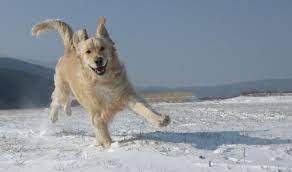

In [ ]:
im(filename="/content/dog_img.jpg",width = 400, height = 300)

In [ ]:
model.eval()
test_image_a = transform(Image.open("/content/dog_img.jpg").convert("RGB")).unsqueeze(0)

print("Example 4 OUPUT: "
+" ".join(model.caption_image(test_image_a.to(device),data.vocab)))

Example 4 OUPUT: <SOS> a dog runs through the snow . <EOS>
